## Load packages 

In [35]:
import pandas as pd
import altair as alt
from vega_datasets import data
import pandas_profiling
import seaborn as sns
import numpy as np

# Need to enable this to allow work with larger datasets (https://altair-viz.github.io/user_guide/faq.html)
alt.data_transformers.enable('json')

# Need to enable this to render in notebook
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Loading datasets

In [15]:
# World Bank data
raw_df = pd.read_csv('../data/GDIMMay2018.csv')
raw_df.head()

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.1
3,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25396.0,0.050447,18387.0,0.218062,NaN,NaN,NaN,NaN,0.1
4,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12246.0,0.047961,8677.0,0.230909,NaN,NaN,NaN,NaN,0.1


In [16]:
# country code data to be able to plot on choropleth
country_code = pd.read_csv('https://pkgstore.datahub.io/JohnSnowLabs/country-and-continent-codes-list/country-and-continent-codes-list-csv_csv/data/b7876b7f496677669644f3d1069d3121/country-and-continent-codes-list-csv_csv.csv')

# rename column so it can be joined later 
country_code = country_code.rename(columns={"Three_Letter_Country_Code": 'iso3'})
country_code.head()

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,iso3,Country_Number
0,Asia,AS,"Afghanistan, Islamic Republic of",AF,AFG,4.0
1,Europe,EU,"Albania, Republic of",AL,ALB,8.0
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),AQ,ATA,10.0
3,Africa,AF,"Algeria, People's Democratic Republic of",DZ,DZA,12.0
4,Oceania,OC,American Samoa,AS,ASM,16.0


## Wrangling

In [17]:
# drop rows where we don't have education mobility info, and drop unneeded columns
raw_df = raw_df.dropna(subset=['IGP', 'year'])
# keep relevant columns, group by variable categories and report mean IGP (education persistance)
ed_mob_df = raw_df.groupby(['countryname', 'iso3', 'region', 'incgroup2', 'incgroup4', 'year', 'child']).agg({'IGP': 'mean'})
ed_mob_df

IGP
countryname iso3 region                     incgroup2            incgroup4           year child             
Afghanistan AFG  South Asia                 Developing economies Low income          1980 all       0.621688
                                                                                          daughter  0.669084
                                                                                          son       0.622239
Albania     ALB  Europe & Central Asia      Developing economies Upper middle income 1940 all       0.593197
                                                                                          daughter  0.555591
...                                                                                                      ...
Yemen, Rep. YEM  Middle East & North Africa Developing economies Lower middle income 1980 daughter  0.584839
                                                                                          son       0.250859
Zambia      ZMB  Sub-Saharan Africa         Developing economies Lower middle income 1980 all       0.408004
                                                                                          daughter  0.419393
                                                                                          son       0.401627

[1744 rows x 1 columns]

In [18]:
ed_mob_df.describe()

,IGP
count,1744.000000
mean,0.462139
std,0.205675
min,-0.214044
25%,0.322259
50%,0.435497
75%,0.584189
max,2.811221


In [19]:
ed_mob_df.query('IGP > 1')

IGP
countryname iso3 region                     incgroup2            incgroup4           year child             
Bhutan      BTN  South Asia                 Developing economies Lower middle income 1940 son       1.063611
Guatemala   GTM  Latin America & Caribbean  Developing economies Lower middle income 1940 son       1.054758
                                                                                     1950 all       1.031453
                                                                                          son       1.107781
Iraq        IRQ  Middle East & North Africa Developing economies Upper middle income 1940 daughter  1.133166
                                                                                     1950 daughter  1.014136
Lao PDR     LAO  East Asia & Pacific        Developing economies Lower middle income 1950 son       1.017741
Nepal       NPL  South Asia                 Developing economies Low income          1950 son       1.011635
Timor-Leste TLS  East Asia & Pacific        Developing economies Lower middle income 1950 all       1.263025
                                                                                          daughter  1.333655
                                                                                          son       1.272961
Togo        TGO  Sub-Saharan Africa         Developing economies Low income          1950 all       1.017939
                                                                                          son       1.166443
Tunisia     TUN  Middle East & North Africa Developing economies Lower middle income 1940 son       1.163155
Uganda      UGA  Sub-Saharan Africa         Developing economies Low income          1940 daughter  2.811221

In the next cell, I convert the `IGP` (intergenerational persistance) to a new 'education mobility index' (`EMI`) where 1 represents a high mobility and 0 represents the lowest mobility

In [20]:
#find max and min IGP, then calculate EMI by mapping min IGP to 1 and max IGP to 0
max_igp = 1
min_igp = 0
#scale 
ed_mob_df['EMI'] = (1 / (min_igp - max_igp))* (ed_mob_df['IGP'] - max_igp)
ed_mob_df.reset_index(inplace=True)
ed_mob_df.head()

,countryname,iso3,region,incgroup2,incgroup4,year,child,IGP,EMI
0,Afghanistan,AFG,South Asia,Developing economies,Low income,1980,all,0.621688,0.378312
1,Afghanistan,AFG,South Asia,Developing economies,Low income,1980,daughter,0.669084,0.330916
2,Afghanistan,AFG,South Asia,Developing economies,Low income,1980,son,0.622239,0.377761
3,Albania,ALB,Europe & Central Asia,Developing economies,Upper middle income,1940,all,0.593197,0.406803
4,Albania,ALB,Europe & Central Asia,Developing economies,Upper middle income,1940,daughter,0.555591,0.444409


Make each year a column so can merge with country codes and assign NaN values a unique plotting value

In [21]:
ed_mob_wide = pd.pivot_table(ed_mob_df,
                             values=['EMI'],
                             index=['countryname', 'iso3', 'region', 'incgroup2', 'incgroup4', 'child'],
                             columns='year').reset_index()
ed_mob_wide

countryname iso3                      region             incgroup2  \
year                                                                       
0     Afghanistan  AFG                  South Asia  Developing economies   
1     Afghanistan  AFG                  South Asia  Developing economies   
2     Afghanistan  AFG                  South Asia  Developing economies   
3         Albania  ALB       Europe & Central Asia  Developing economies   
4         Albania  ALB       Europe & Central Asia  Developing economies   
..            ...  ...                         ...                   ...   
437   Yemen, Rep.  YEM  Middle East & North Africa  Developing economies   
438   Yemen, Rep.  YEM  Middle East & North Africa  Developing economies   
439        Zambia  ZMB          Sub-Saharan Africa  Developing economies   
440        Zambia  ZMB          Sub-Saharan Africa  Developing economies   
441        Zambia  ZMB          Sub-Saharan Africa  Developing economies   

                incgroup4     child       EMI                                \
year                                     1940      1950      1960      1970   
0              Low income       all       NaN       NaN       NaN       NaN   
1              Low income  daughter       NaN       NaN       NaN       NaN   
2              Low income       son       NaN       NaN       NaN       NaN   
3     Upper middle income       all  0.406803  0.581869  0.622471  0.550479   
4     Upper middle income  daughter  0.444409  0.493345  0.596763  0.520640   
..                    ...       ...       ...       ...       ...       ...   
437   Lower middle income  daughter       NaN       NaN       NaN       NaN   
438   Lower middle income       son       NaN       NaN       NaN       NaN   
439   Lower middle income       all       NaN       NaN       NaN       NaN   
440   Lower middle income  daughter       NaN       NaN       NaN       NaN   
441   Lower middle income       son       NaN       NaN       NaN       NaN   

                
year      1980  
0     0.378312  
1     0.330916  
2     0.377761  
3     0.602419  
4     0.590161  
..         ...  
437   0.415161  
438   0.749141  
439   0.591996  
440   0.580607  
441   0.598373  

[442 rows x 11 columns]

In [22]:
# combine with country codes for plotting
ed_mob_wide_all = pd.merge(ed_mob_wide, country_code, on="iso3", how='outer')
ed_mob_wide_all = ed_mob_wide_all.dropna(subset=['Country_Number'])
ed_mob_wide_all.columns = ['iso3', 'countryname', 'iso3', 'region', 'incgroup2', 'incgroup4', 'child',
                                            '1940', '1950', '1960', '1970', '1980', 'continent', 'cont_code', 'long_country_name', 'two_letter_country', 'country_num']
ed_mob_wide_all = ed_mob_wide_all.drop(['iso3', 'cont_code', 'long_country_name', 'two_letter_country'], axis=1)
#save one version with NaN values
ed_mob_wide_all_NaN = ed_mob_wide_all

#save one version with NaN replaced with -999
ed_mob_wide_all_final = ed_mob_wide_all.fillna(value=-999)
ed_mob_wide_all_final

,countryname,region,incgroup2,incgroup4,child,1940,1950,1960,1970,1980,continent,country_num
0,Afghanistan,South Asia,Developing economies,Low income,all,-999.000000,-999.000000,-999.000000,-999.000000,0.378312,Asia,4.0
1,Afghanistan,South Asia,Developing economies,Low income,daughter,-999.000000,-999.000000,-999.000000,-999.000000,0.330916,Asia,4.0
2,Afghanistan,South Asia,Developing economies,Low income,son,-999.000000,-999.000000,-999.000000,-999.000000,0.377761,Asia,4.0
3,Albania,Europe & Central Asia,Developing economies,Upper middle income,all,0.406803,0.581869,0.622471,0.550479,0.602419,Europe,8.0
4,Albania,Europe & Central Asia,Developing economies,Upper middle income,daughter,0.444409,0.493345,0.596763,0.520640,0.590161,Europe,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
562,-999,-999,-999,-999,-999,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,Europe,832.0
563,-999,-999,-999,-999,-999,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,Europe,833.0
564,-999,-999,-999,-999,-999,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,North America,850.0
565,-999,-999,-999,-999,-999,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,Oceania,876.0


In [23]:
ed_mob_1940 = ed_mob_df.loc[ed_mob_df['year'] == 1940]

ed_mob_1950 = ed_mob_df.loc[ed_mob_df['year'] == 1950]
ed_mob_1960 = ed_mob_df.loc[ed_mob_df['year'] == 1960]
ed_mob_1970 = ed_mob_df.loc[ed_mob_df['year'] == 1970]
ed_mob_1980 = ed_mob_df.loc[ed_mob_df['year'] == 1980]

ed_mob_1940 = ed_mob_1940.rename(columns={"EMI": "1940"})
ed_mob_1950 = ed_mob_1950.rename(columns={"EMI": "1950"})
ed_mob_1960 = ed_mob_1960.rename(columns={"EMI": "1960"})
ed_mob_1970 = ed_mob_1970.rename(columns={"EMI": "1970"})
ed_mob_1980 = ed_mob_1980.rename(columns={"EMI": "1980"})

In [42]:
ed_mob_wide_all_NaN = ed_mob_wide_all_NaN.dropna(subset=['countryname'])

In [43]:
ed_mob_wide_all_NaN

,countryname,region,incgroup2,incgroup4,child,1940,1950,1960,1970,1980,continent,country_num
0,Afghanistan,South Asia,Developing economies,Low income,all,NaN,NaN,NaN,NaN,0.378312,Asia,4.0
1,Afghanistan,South Asia,Developing economies,Low income,daughter,NaN,NaN,NaN,NaN,0.330916,Asia,4.0
2,Afghanistan,South Asia,Developing economies,Low income,son,NaN,NaN,NaN,NaN,0.377761,Asia,4.0
3,Albania,Europe & Central Asia,Developing economies,Upper middle income,all,0.406803,0.581869,0.622471,0.550479,0.602419,Europe,8.0
4,Albania,Europe & Central Asia,Developing economies,Upper middle income,daughter,0.444409,0.493345,0.596763,0.520640,0.590161,Europe,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
458,"Yemen, Rep.",Middle East & North Africa,Developing economies,Lower middle income,daughter,NaN,NaN,NaN,NaN,0.415161,Asia,887.0
459,"Yemen, Rep.",Middle East & North Africa,Developing economies,Lower middle income,son,NaN,NaN,NaN,NaN,0.749141,Asia,887.0
460,Zambia,Sub-Saharan Africa,Developing economies,Lower middle income,all,NaN,NaN,NaN,NaN,0.591996,Africa,894.0
461,Zambia,Sub-Saharan Africa,Developing economies,Lower middle income,daughter,NaN,NaN,NaN,NaN,0.580607,Africa,894.0


## Plotting

In [25]:
# json base country map data 
country_map = alt.topo_feature(data.world_110m.url, 'countries')

In [26]:
def map_and_bar_by_year(year, title):
    """
    ADD DOCUMENTATION HERE
    """
    quote_yr = str(year)
    selection = alt.selection_multi(fields=[quote_yr], resolve='global')
    
    map_chart = alt.Chart(country_map).mark_geoshape(
        stroke='white',
        fill='lightgray'
    ).encode(
        color=alt.condition(selection,
                           alt.Color(quote_yr, type='quantitative',
                                    scale=alt.Scale(domain=[0, 1])),
                           alt.value('lightgray')),
        tooltip = [
            alt.Tooltip('countryname:N', title="country"),
            alt.Tooltip(f'{year}:Q', title="EMI")
        ]
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(ed_mob_wide_all_final,'country_num', [quote_yr, 'countryname'])
    ).properties(
        width=600
    ).project(
        'equirectangular'
    ).resolve_scale(
        color='independent'
    ).properties(title=title,
                height=500,
                width=400).add_selection(selection)
    
    plot_dict = {
        1940: ed_mob_1940,
        1950: ed_mob_1950,
        1960: ed_mob_1960,
        1970: ed_mob_1970,
        1980: ed_mob_1980
    }
    
    bar_chart_data = plot_dict[year]
    
    bar_chart = alt.Chart(bar_chart_data.loc[bar_chart_data['child'] == 'all']).mark_bar().encode(
        alt.X(f'{quote_yr}:Q', title="Education Mobility Index"),
        alt.Y('countryname', title='',
        sort=alt.EncodingSortField(field=quote_yr,
                                   order="descending")),
        #color=alt.Color('incgroup2'),
        color=alt.condition(selection,
                           'incgroup2',
                           alt.value('lightgray')),
        tooltip = [
            alt.Tooltip('countryname:N', title="country"),
            alt.Tooltip(f'{quote_yr}:Q', title="EMI")
        ]
    ).properties(height = 400, width = 200).add_selection(selection)
    
    return map_chart | bar_chart

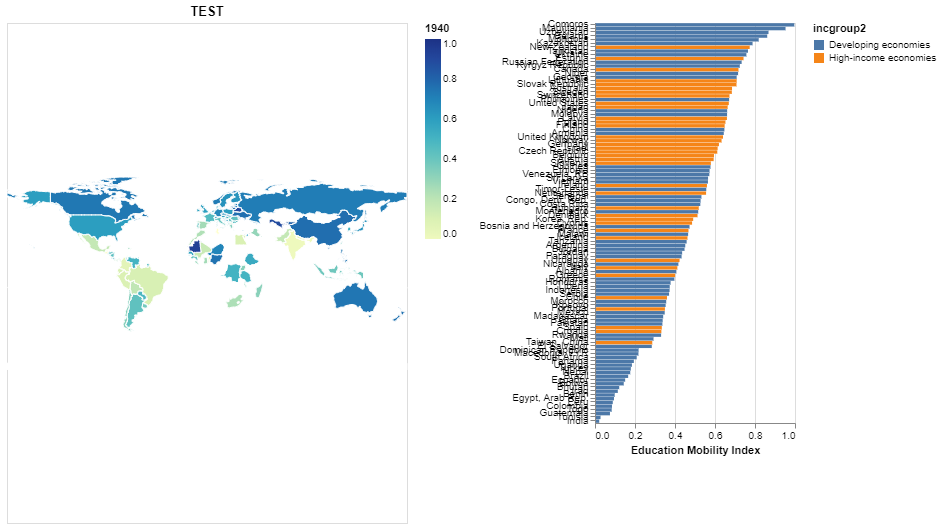

In [27]:
map_and_bar_by_year(1940, "TEST")

In [28]:
def map_and_bar_by_year(year, title):
    """
    ADD DOCUMENTATION HERE
    """
    quote_yr = str(year)
    selection = alt.selection_multi(fields = [quote_yr], resolve='global')
    
    map_chart = alt.Chart(country_map).mark_geoshape(
        stroke='white',
        fill='lightgray'
    ).encode(
        color=alt.condition(selection,
                           alt.Color(quote_yr, type='quantitative',
                                    scale=alt.Scale(domain=[0, 1])),
                           alt.value('lightgray')),
        tooltip = [
            alt.Tooltip('countryname:N', title="country"),
            alt.Tooltip(f'{year}:Q', title="EMI")
        ]
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(ed_mob_wide_all_final,'country_num', [quote_yr, 'countryname'])
    ).properties(
        width=600
    ).project(
        'equirectangular'
    ).resolve_scale(
        color='independent'
    ).properties(title=title,
                height=400,
                width=600).add_selection(selection)
    
    plot_dict = {
        '1940': ed_mob_1940,
        '1950': ed_mob_1950,
        '1960': ed_mob_1960,
        '1970': ed_mob_1970,
        '1980': ed_mob_1980
    }
    
    bar_chart_data = plot_dict[quote_yr]
    
    bar_chart = alt.Chart(bar_chart_data.loc[bar_chart_data['child'] == 'all']).mark_bar().encode(
        alt.Y(f'{quote_yr}:Q', title="Education Mobility Index"),
        alt.X('countryname', title='',
        sort=alt.EncodingSortField(field=quote_yr,
                                   order="descending")),
        #color=alt.Color('incgroup2'),
        color=alt.condition(selection,
                           'incgroup2',
                           alt.value('lightgray')),
        tooltip = [
            alt.Tooltip('countryname:N', title="country"),
            alt.Tooltip(f'{quote_yr}:Q', title="EMI")
        ]
    ).properties(height = 100, width = 600).add_selection(selection)
    
    return map_chart & bar_chart

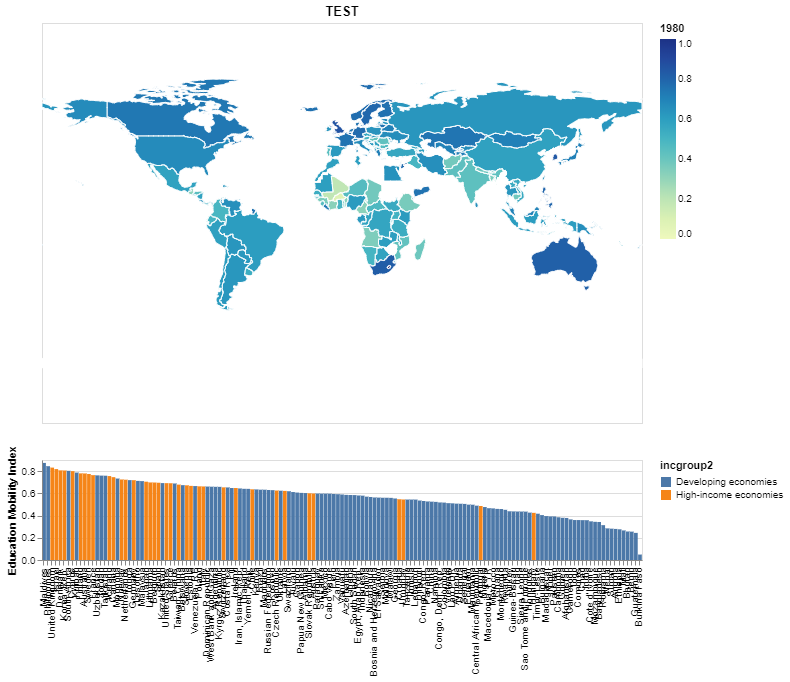

In [29]:
map_and_bar_by_year(1980, "TEST")

In [30]:
selector = alt.selection_single(empty='all', fields=['1940'])



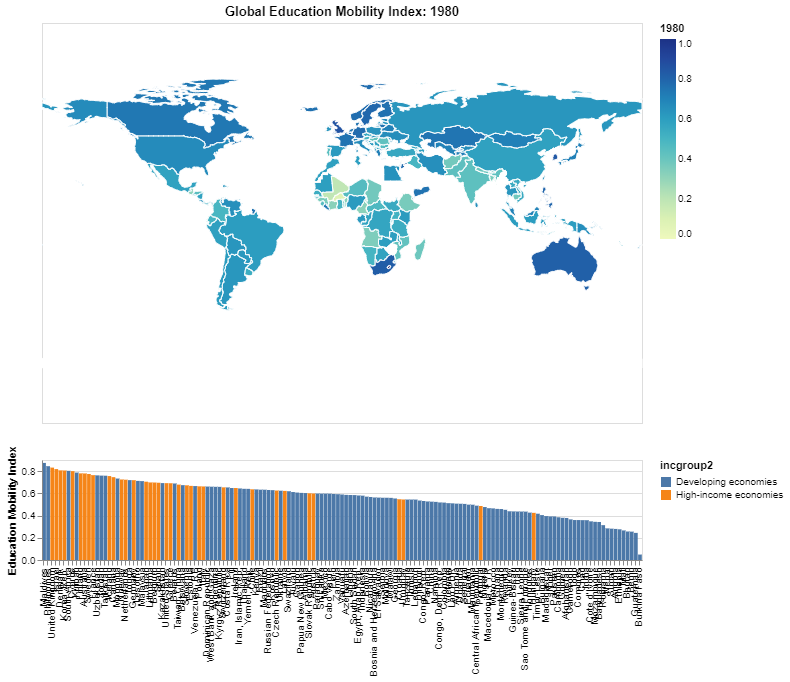

In [68]:
def map_and_bar_by_year(year, title):
    """
    ADD DOCUMENTATION HERE
    """
    quote_yr = str(year)
    selection = alt.selection_multi(fields = ['countryname'], resolve='global')
    
    map_chart = alt.Chart(country_map).mark_geoshape(
        stroke='white',
        fill='lightgray'
    ).encode(
        color=alt.condition(selection,
                           alt.Color(quote_yr, type='quantitative',
                                    scale=alt.Scale(domain=[0, 1])),
                           alt.value('lightgray')),
        tooltip = [
            alt.Tooltip('countryname:N', title="country"),
            alt.Tooltip(f'{year}:Q', title="EMI")
        ]
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(ed_mob_wide_all_final,'country_num', [quote_yr, 'countryname'])
    ).properties(
        width=600
    ).project(
        'equirectangular'
   # ).resolve_scale(
       # color='independent'
    ).properties(title=title,
                height=400,
                width=600).add_selection(selection)
    
    plot_dict = {
        '1940': ed_mob_1940,
        '1950': ed_mob_1950,
        '1960': ed_mob_1960,
        '1970': ed_mob_1970,
        '1980': ed_mob_1980
    }
    
    bar_chart_data = plot_dict[quote_yr]
    
    bar_chart = alt.Chart(bar_chart_data.loc[bar_chart_data['child'] == 'all']).mark_bar().encode(
        alt.Y(f'{quote_yr}:Q', title="Education Mobility Index"),
        alt.X('countryname', title='',
        sort=alt.EncodingSortField(field=quote_yr,
                                   order="descending")),
        #color=alt.Color('incgroup2'),
        color=alt.condition(selection,
                           'incgroup2',
                           alt.value('lightgray')),
        tooltip = [
            alt.Tooltip('countryname:N', title="country"),
            alt.Tooltip(f'{quote_yr}:Q', title="EMI")
        ]
    ).properties(height = 100, width = 600).add_selection(selection)
    
    return map_chart & bar_chart

year = 1980
title = f'Global Education Mobility Index: {year}'
map_and_bar_by_year(year, title)

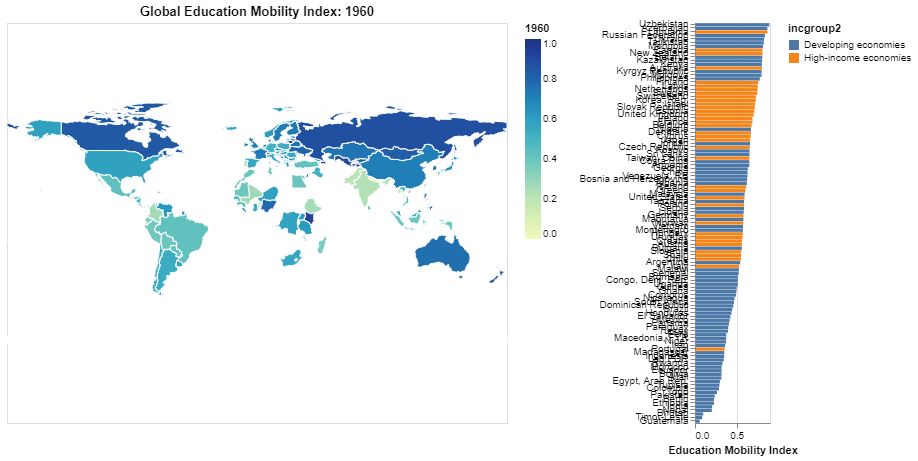

In [72]:
def map_and_bar_by_year(year, title):
    """
    ADD DOCUMENTATION HERE
    """
    quote_yr = str(year)
    selection = alt.selection_multi(fields = ['countryname'], resolve='global')
    
    map_chart = alt.Chart(country_map).mark_geoshape(
        stroke='white',
        fill='lightgray'
    ).encode(
        color=alt.condition(selection,
                           alt.Color(quote_yr, type='quantitative',
                                    scale=alt.Scale(domain=[0, 1])),
                           alt.value('lightgray')),
        tooltip = [
            alt.Tooltip('countryname:N', title="country"),
            alt.Tooltip(f'{year}:Q', title="EMI")
        ]
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(ed_mob_wide_all_final,'country_num', [quote_yr, 'countryname'])
    ).properties(
        width=600
    ).project(
        'equirectangular'
   # ).resolve_scale(
       # color='independent'
    ).properties(title=title,
                height=400,
                width=500).add_selection(selection)
    
    plot_dict = {
        '1940': ed_mob_1940,
        '1950': ed_mob_1950,
        '1960': ed_mob_1960,
        '1970': ed_mob_1970,
        '1980': ed_mob_1980
    }
    
    bar_chart_data = plot_dict[quote_yr]
    
    bar_chart = alt.Chart(bar_chart_data.loc[bar_chart_data['child'] == 'all']).mark_bar().encode(
        alt.X(f'{quote_yr}:Q', title="Education Mobility Index"),
        alt.Y('countryname', title='',
        sort=alt.EncodingSortField(field=quote_yr,
                                   order="descending")),
        #color=alt.Color('incgroup2'),
        color=alt.condition(selection,
                           'incgroup2',
                           alt.value('lightgray')),
        tooltip = [
            alt.Tooltip('countryname:N', title="country"),
            alt.Tooltip(f'{quote_yr}:Q', title="EMI")
        ]
    ).properties(height = 400, width = 75).add_selection(selection)
    
    return map_chart | bar_chart

year = 1960
title = f'Global Education Mobility Index: {year}'
map_and_bar_by_year(year, title)

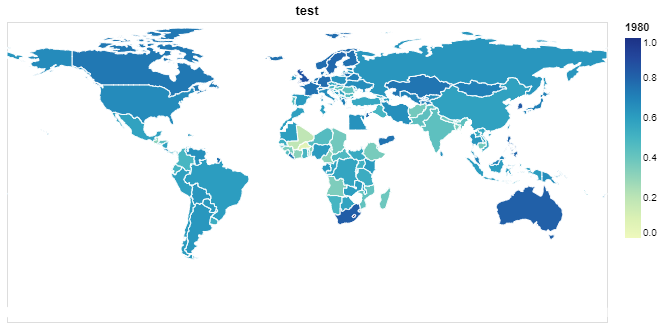

In [154]:
alt.Chart(country_map).mark_geoshape(
    stroke='white',
    fill='lightgray'
).encode(
    alt.Color('1980', type='quantitative', scale=alt.Scale(domain=[0, 1])),
    tooltip = [
        alt.Tooltip('countryname:N', title="country"),
        alt.Tooltip('1980:Q', title="EMI")
    ]
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(ed_mob_wide_all_final,'country_num', ['1980','countryname'])
).properties(
    width=600
).project(
    'equirectangular'
).resolve_scale(
    color='independent'
).properties(title="test")

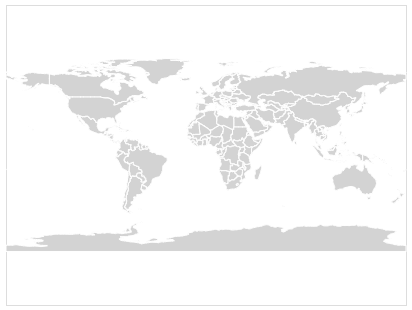

In [69]:
base = alt.Chart(country_map).mark_geoshape(
    stroke='white',
    fill='lightgray'
)
base.project(
    'equirectangular'
)